# Import needed modules

In [ ]:
import tensorflow as tf

# Check available devices
devices = tf.config.list_physical_devices()


# Print device information
for device in devices:
    print(f"Device name: {device.name}")
    print(f"Device type: {device.device_type}")
    print("-----")

Device name: /physical_device:CPU:0
Device type: CPU
-----
Device name: /physical_device:GPU:0
Device type: GPU
-----


In [ ]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **1- Read data and store it in dataframe**

In [ ]:
data_dir = 'F:/NoteBooks/Militaire/Pneumonia/input/chest-xray-pneumonia/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,NORMAL
1,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,NORMAL
2,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,NORMAL
3,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,NORMAL
4,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,NORMAL
...,...,...
5212,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,PNEUMONIA
5213,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,PNEUMONIA
5214,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,PNEUMONIA
5215,F:/NoteBooks/Militaire/Pneumonia/input/chest-x...,PNEUMONIA


### **2- Split dataframe into train, valid, and test**

In [ ]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **3- Create image data generator**

In [ ]:

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4173 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


### **4- Show sample from train data**

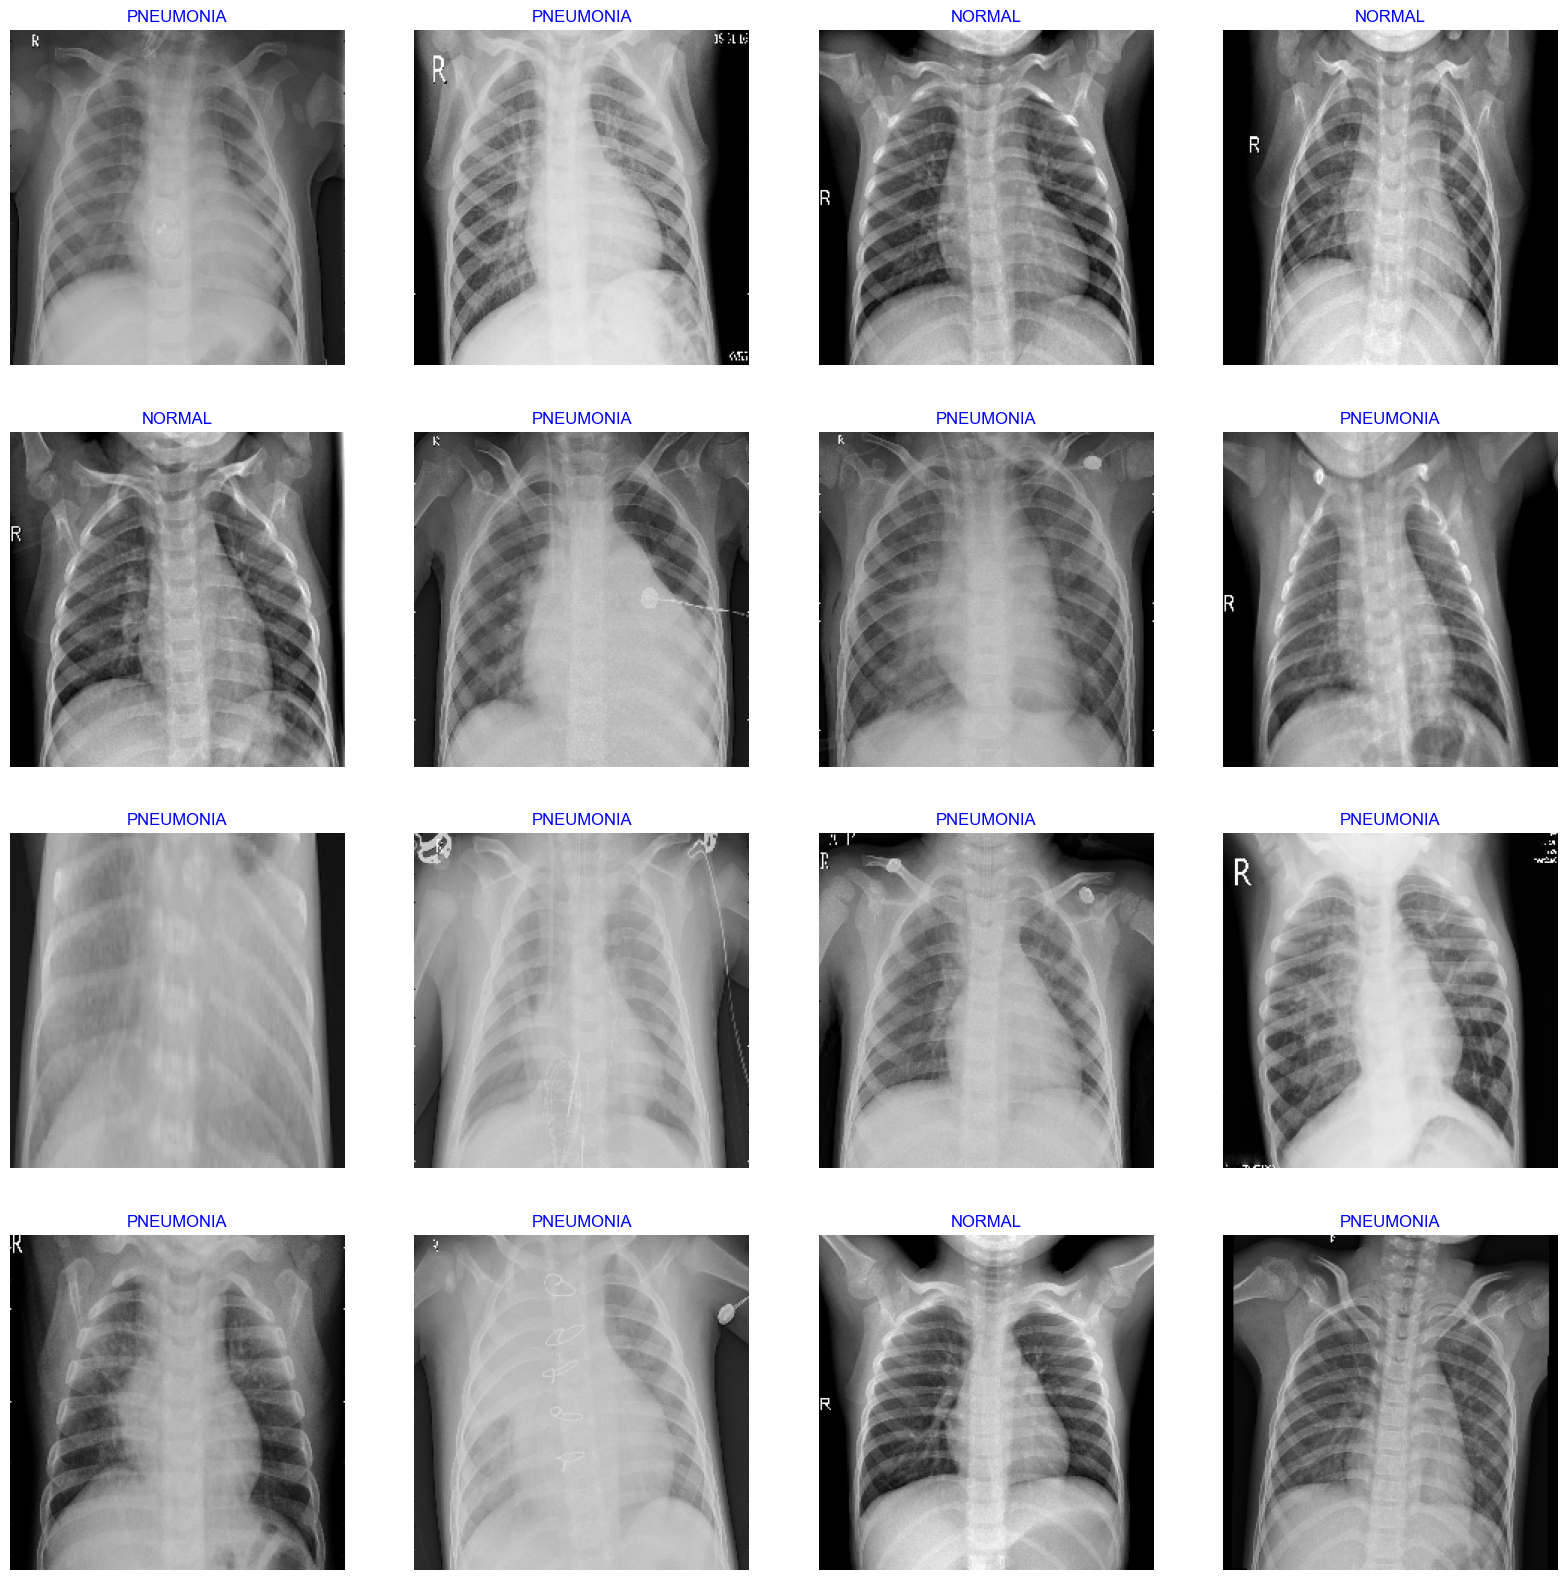

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255    # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 4,383,141
Trainable params: 4,338,558
Non-trainable params: 44,583
_________________________________________________________________


#### **Train model**

In [ ]:
batch_size = 16
epochs = 10

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
261/261 [==============================] - 355s 1s/step - loss: 4.5418 - accuracy: 0.9360 - val_loss: 2.8886 - val_accuracy: 0.8642
Epoch 2/10
261/261 [==============================] - 330s 1s/step - loss: 1.9659 - accuracy: 0.9722 - val_loss: 1.4432 - val_accuracy: 0.9249
Epoch 3/10
261/261 [==============================] - 347s 1s/step - loss: 1.0146 - accuracy: 0.9803 - val_loss: 0.6993 - val_accuracy: 0.9840
Epoch 4/10
261/261 [==============================] - 331s 1s/step - loss: 0.5545 - accuracy: 0.9837 - val_loss: 0.4492 - val_accuracy: 0.9649
Epoch 5/10
261/261 [==============================] - 330s 1s/step - loss: 0.3326 - accuracy: 0.9878 - val_loss: 0.2468 - val_accuracy: 0.9936
Epoch 6/10
261/261 [==============================] - 329s 1s/step - loss: 0.2331 - accuracy: 0.9880 - val_loss: 0.1858 - val_accuracy: 0.9904
Epoch 7/10
261/261 [==============================] - 325s 1s/step - loss: 0.1798 - accuracy: 0.9911 - val_loss: 0.1514 - val_accuracy: 0.9920

#### **Display model performance**

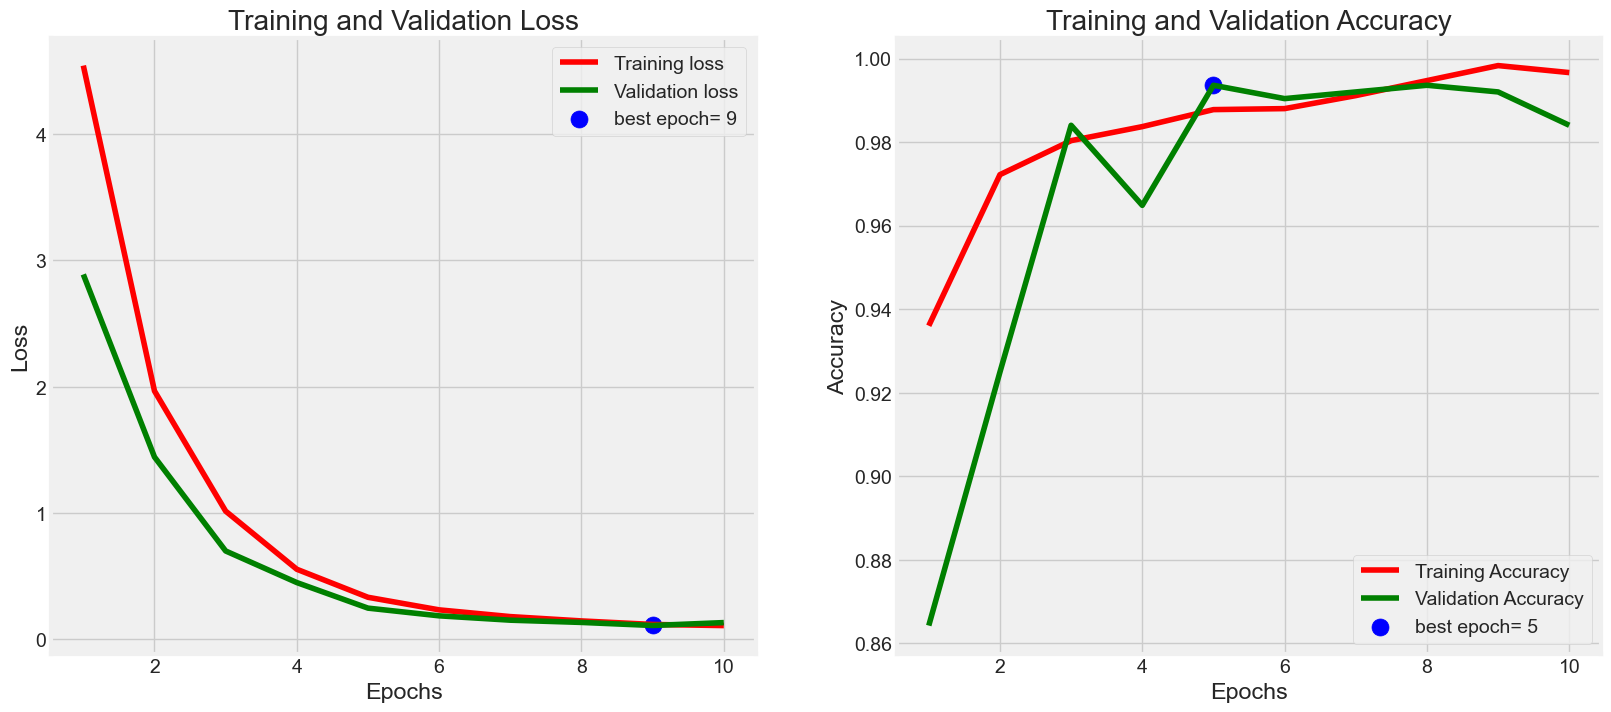

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 16s 701ms/step - loss: 0.1186 - accuracy: 0.9880
Train Loss:  0.10537547618150711
Train Accuracy:  0.9943181872367859
--------------------
Validation Loss:  0.14865468442440033
Validation Accuracy:  0.9715909361839294
--------------------
Test Loss:  0.11863178014755249
Test Accuracy:  0.9880383014678955


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

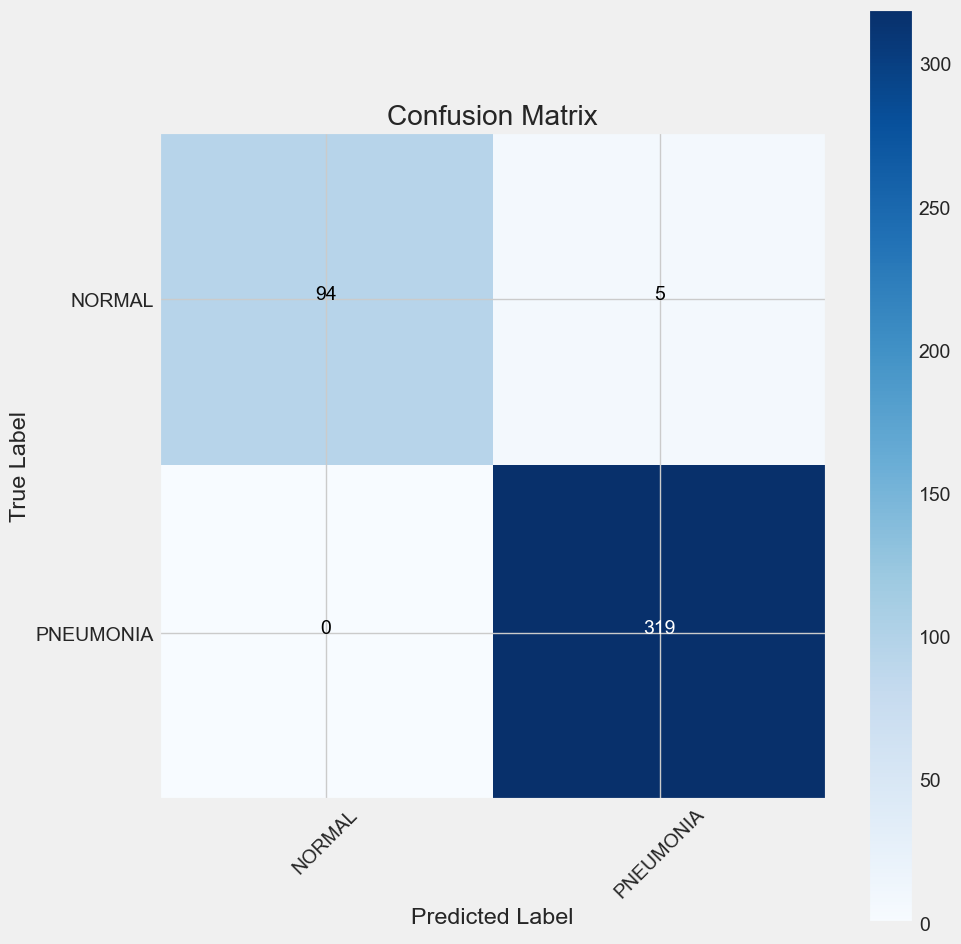

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       1.00      0.95      0.97        99
   PNEUMONIA       0.98      1.00      0.99       319

    accuracy                           0.99       418
   macro avg       0.99      0.97      0.98       418
weighted avg       0.99      0.99      0.99       418



#### **Save model**

1- h5

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'Walid Jlassi Works'
acc = test_score[1] * 100
save_path = 'F:/NoteBooks/Militaire/Pneumonia/ModelsFinal'

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as F:/NoteBooks/Militaire/Pneumonia/ModelsFinal\efficientnetb0-Walid Jlassi Works-98.80.h5
weights were saved as F:/NoteBooks/Militaire/Pneumonia/ModelsFinal\efficientnetb0-Walid Jlassi Works-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as F:/NoteBooks/Militaire/Pneumonia/ModelsFinal\Walid Jlassi Works-class_dict.csv


# ------------------ TEST ----------------------

In [ ]:
final_model = tf.keras.models.load_model('F:/NoteBooks/Militaire/Pneumonia/ModelsFinal/PneumoniaDetection.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Define the class labels
class_labels = ['Normal', 'Pneumonia']

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image_class(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = round(prediction[0][predicted_class] * 100, 2)
    class_label = class_labels[predicted_class]
    return class_label, confidence

# Path to the image you want to predict
image_path = 'F:/NoteBooks/Militaire/Pneumonia/input/chest-xray-pneumonia/train/PNEUMONIA/R.jpg'

# Predict the class of the image
predicted_class, confidence = predict_image_class(image_path)
print('Predicted Class:', predicted_class)
print('Confidence:', confidence, '%')

Predicted Class: Pneumonia
Confidence: 88.32 %


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Define the class labels
class_labels = ['Normal', 'Pneumonia']

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image_class(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = round(prediction[0][predicted_class] * 100, 2)
    class_label = class_labels[predicted_class]
    return class_label, confidence

# Path to the image you want to predict
image_path = 'F:/NoteBooks/Militaire/Pneumonia/input/chest-xray-pneumonia/test/NORMAL/IM-0063-0001.jpeg'

# Predict the class of the image
predicted_class, confidence = predict_image_class(image_path)
print('Predicted Class:', predicted_class)
print('Confidence:', confidence, '%')

Predicted Class: Normal
Confidence: 86.98 %
